# **1. Gather the Data**

Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed

 * `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

# **2. Import Libraries & Reading the Data**

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,cross_val_predict
import time
import string

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set()

dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Use DataFrame.loc attribute to access a particular cell in the given Dataframe using the index and column labels.
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
    # Returns divided dfs of training and test set 

df_all = concat_df(dftrain, dftest)

dftrain.name = 'Training Set'
dftest.name = 'Test Set'
df_all.name = 'All Set' 

## **3. Data Understanding**


In [2]:
total = dftrain.isnull().sum().sort_values(ascending=False)
percent_1 = dftrain.isnull().sum()/dftrain.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


In [3]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
total = dftest.isnull().sum().sort_values(ascending=False)
percent_1 = dftest.isnull().sum()/dftest.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2
Embarked,0,0.0
Ticket,0,0.0


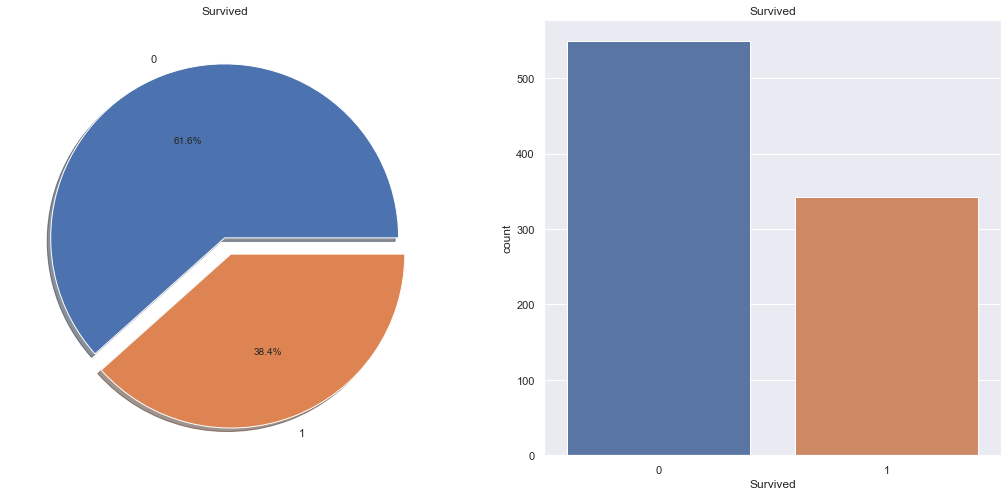

In [4]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
#How Many Servived?

f,ax=plt.subplots(1,2,figsize=(18,8)) # 1 row , 2 columns subplots 
dftrain['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)

ax[0].set_title('Survived') 
ax[0].set_ylabel('')

sns.countplot('Survived',data=dftrain,ax=ax[1])

ax[1].set_title('Survived') # ax[0] & ax[1] are different axis for different plots.

plt.show()

Out of 891 passengers in training set, only around 350 survived i.e Only 38.4% of the total training set survived the crash. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't.

In [5]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

df_all_corr[df_all_corr['Feature 1'] == 'Pclass'] 

,Feature 1,Feature 2,Correlation Coefficient
4,Pclass,Pclass,1.000000
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
13,Pclass,Survived,0.338481
32,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
43,Pclass,Parch,0.018322


Missing values in Age are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its **high correlation** `Age` (0.408106) and `Survived` (0.338481). It is also more logical to group ages by passenger classes instead of other features.


When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median Age than males. The median ages below are used for filling the missing values in Age feature.

In [6]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {} '.format(pclass, sex, age_by_pclass_sex[sex][pclass].astype(int)))

Median age of Pclass 1 females: 36 
Median age of Pclass 1 males: 42 
Median age of Pclass 2 females: 28 
Median age of Pclass 2 males: 29 
Median age of Pclass 3 females: 22 
Median age of Pclass 3 males: 25 


**PClass & Embarked & SubSp & Parch**

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

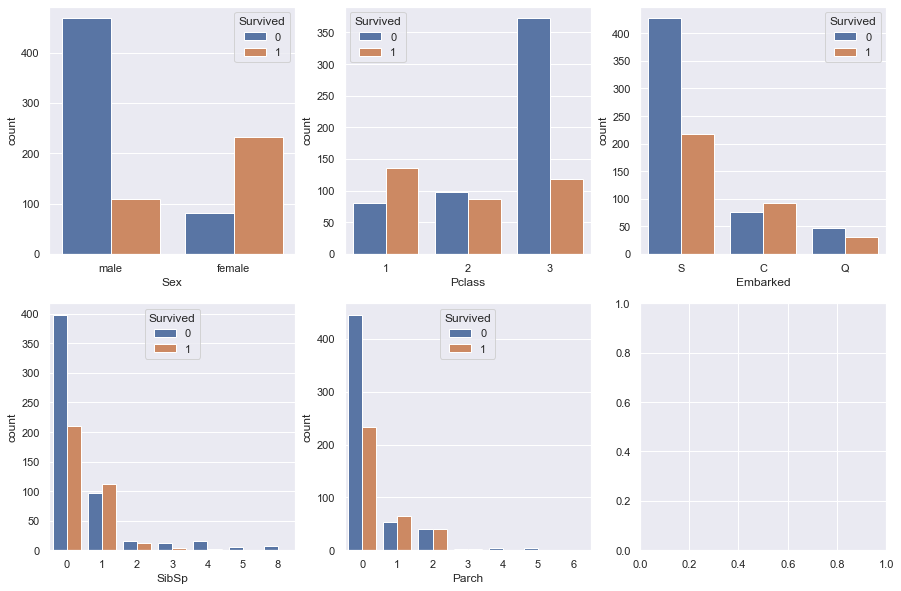

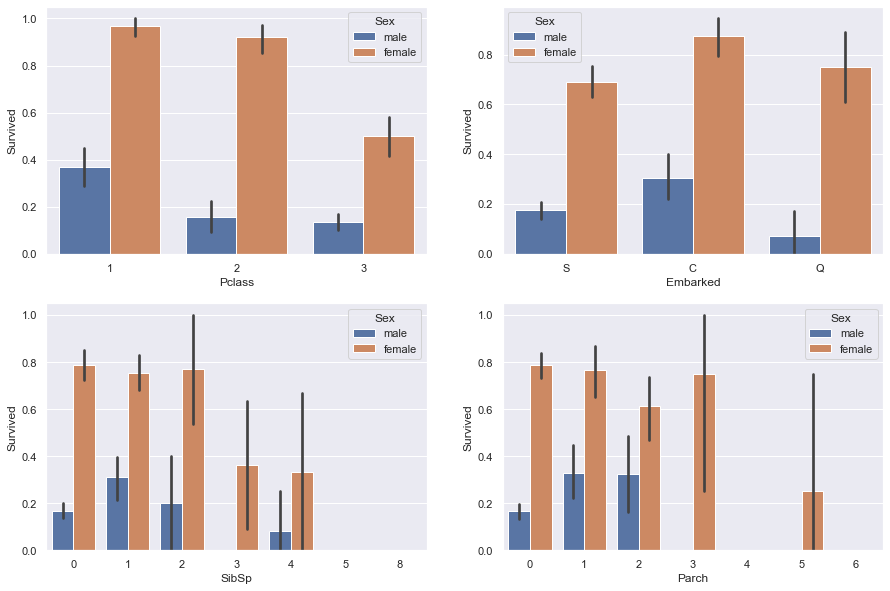

In [7]:

fig, ax = plt.subplots(2,3, figsize=(15,10))
sns.countplot(x='Sex',data=dftrain, hue='Survived', ax=ax[0,0])
sns.countplot(x='Pclass', data=dftrain, hue='Survived', ax=ax[0,1])
sns.countplot(x='Embarked', data=dftrain, hue='Survived', ax=ax[0,2])
sns.countplot(x='SibSp', data=dftrain, hue='Survived', ax=ax[1,0])
sns.countplot(x='Parch', data=dftrain, hue='Survived', ax=ax[1,1])

fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.barplot(x='Pclass', y='Survived',hue='Sex',data=dftrain,ax=ax[0,0])
sns.barplot(x='Embarked', y='Survived',hue='Sex',data=dftrain, ax=ax[0,1])
sns.barplot(x='SibSp', y='Survived',hue='Sex',data=dftrain, ax=ax[1,0])
sns.barplot(x='Parch', y='Survived',hue='Sex',data=dftrain, ax=ax[1,1])


**Fare & Age**

Text(0.5, 1.0, 'Age Distribution Boxplot By Gender')

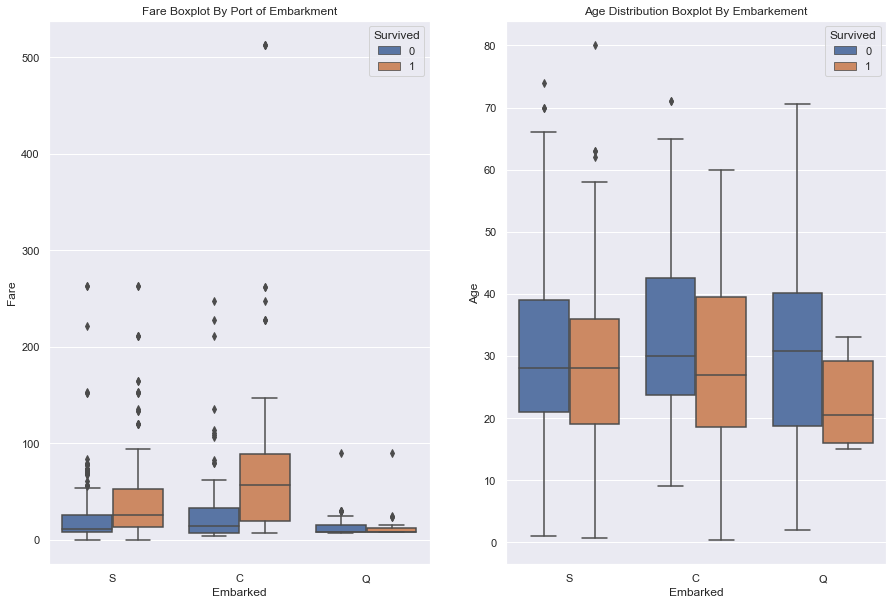

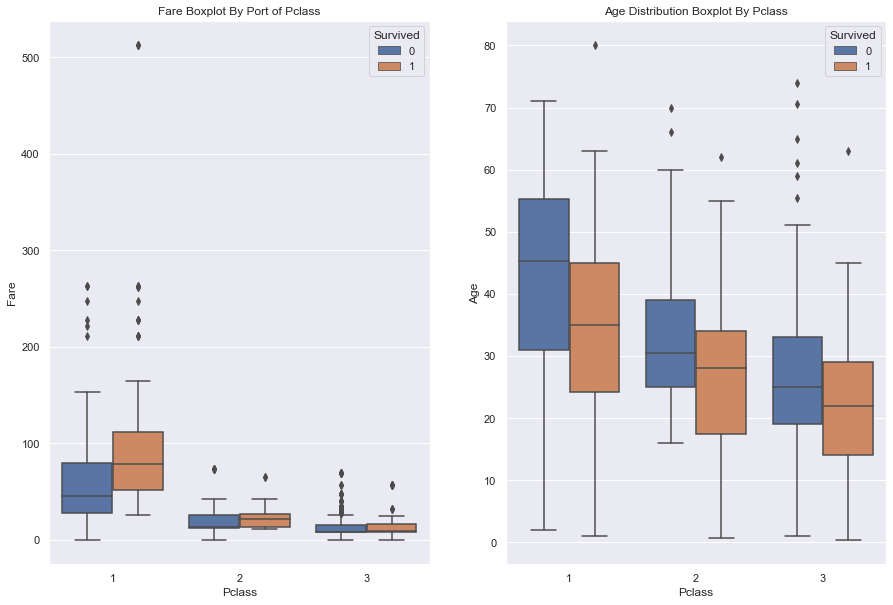

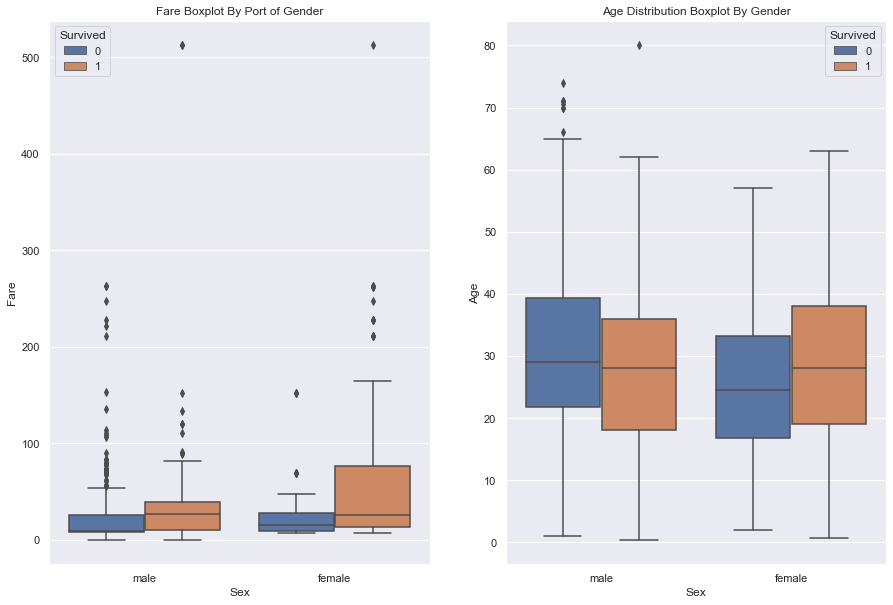

In [8]:
#Embarked
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.boxplot(x='Embarked', y='Fare', hue='Survived', data=dftrain, ax=ax[0])
sns.boxplot(x='Embarked', y='Age', hue='Survived', data=dftrain, ax=ax[1])

ax[0].set_title('Fare Boxplot By Port of Embarkment')
ax[1].set_title('Age Distribution Boxplot By Embarkement')

#Pclass
fig, ax = plt.subplots(1,2, figsize=(15, 10))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=dftrain, ax=ax[0])
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=dftrain, ax=ax[1])

ax[0].set_title('Fare Boxplot By Port of Pclass')
ax[1].set_title('Age Distribution Boxplot By Pclass')

#Sex
fig, ax = plt.subplots(1,2, figsize=(15, 10))
sns.boxplot(x='Sex', y='Fare', hue='Survived', data=dftrain, ax=ax[0])
sns.boxplot(x='Sex', y='Age', hue='Survived', data=dftrain, ax=ax[1])

ax[0].set_title('Fare Boxplot By Port of Gender')
ax[1].set_title('Age Distribution Boxplot By Gender')


Text(0.5, 1.0, 'Surviors by Age')

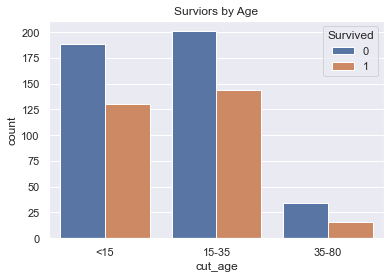

In [9]:
cut_labels = ['<15', '15-35', '35-80']
cut_df = dftrain
cut_df['cut_age'] = pd.cut(cut_df['Age'], bins=3, labels=cut_labels)
age_bin_df = cut_df.groupby(['cut_age']).sum()
g = sns.countplot(data=cut_df, x='cut_age', hue='Survived')
g.set_title('Surviors by Age')

In [10]:
dftrain['Fare'].describe()
#dftrain.Fare.median()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

`Embarked` seems to be correlated with `survival`, depending on the `Sex` and `Pclass`.
Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

## **4. Data Preparation**

#### **Embarked**
Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [11]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### **Fare**
 Filling the missing values in Fare with the medians of Pclass,Parch,SibSp groups
 
There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [12]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### **Age**
 Filling the missing values in Age with the medians of Sex and Pclass groups

In [13]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

#### **Correlation**

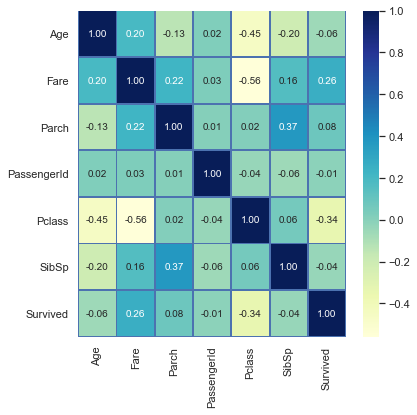

In [14]:
#Correlation
plt.figure(figsize = (6,6))
cor = df_all.corr()
g=sns.heatmap(cor, annot=True, cmap='YlGnBu', linewidths =0.8, linecolor ='b', fmt='.2f')
g.set_yticklabels(g.get_yticklabels(), rotation =0)
plt.show()

#### **Cabin**
Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
#`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself cant be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` 
values are the decks in which the cabins are located. 
Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers

    A   B   C   D   E   F  G    M  T
1  22  65  94  40  34   0  0   67  1
2   0   0   0   6   4  13  0  254  0
3   0   0   0   0   3   8  5  693  0
_________________________


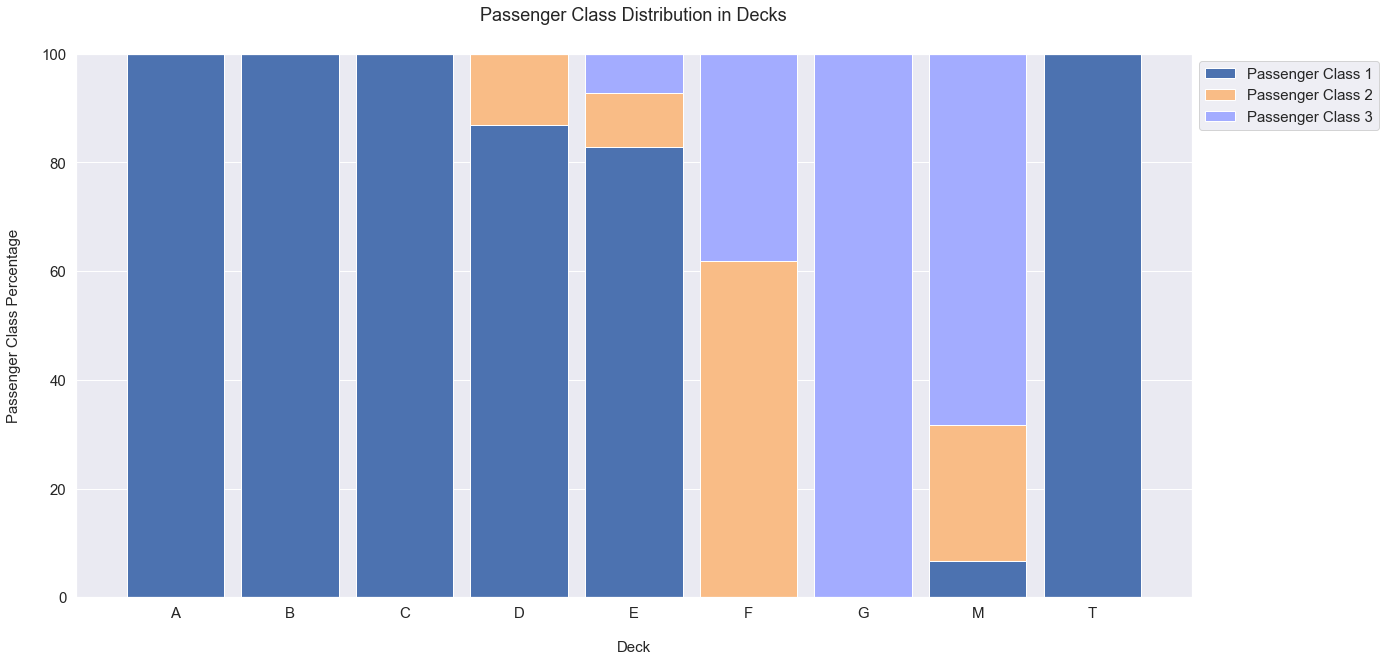

In [15]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
# Creating Deck column by extracting the first letter of the Cabin(string s) column M stands for Missing
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')  #Missing


df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 
                                                                        'Ticket']).rename(columns={'Name': 'Count'})

# Transpose is done for accessbility
df_all_decks=df_all_decks.transpose()


def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    
    #Deck column is extracted from df_all_decks 
    decks = df.columns.levels[0]    
    
    # Creating a new dataframe just a copy of df_all_decks with 0 in respective Pclass if empty ... See Output below.
    # Start
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts) 
    # End
    
    deck_percentages = {}
   
    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages,df_decks


all_deck_count, all_deck_per,df_decks_return = get_pclass_dist(df_all_decks)

print(df_decks_return)

print("_"*25)

def display_pclass_dist(percentages):
    
    #converting dictionary to dataframe and then transpose
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    
    # link --> https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
    plt.bar(bar_count, pclass1,width=bar_width,edgecolor='white',label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='best',bbox_to_anchor=(1, 1),prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks',size=18, y=1.05)   
    
    plt.show()    
    
display_pclass_dist(all_deck_per)    



* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [16]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'


# Same Method is applied as above just this time , deck is grouped with 'Survived' Feature

df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all.drop(['Cabin'], inplace=True, axis=1)

#### ***Create New Features***
***Is_Married, Survival_Rate, Survival_Rate_NA***

In [17]:
#Reference from https://www.kaggle.com/kushal1506/titanic-81-1-leader-board-score-guaranteed
######## Fare ############################################## 

df_all['Fare'] = pd.qcut(df_all['Fare'], 13) # visit the link above

######## Age ############################################## 

df_all['Age'] = pd.qcut(df_all['Age'], 10)

######## SibSp and Parch ########################################  

df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

# Mapping Family Size
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

########Ticket###########################################   
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

######## Name ##############################################   
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]


df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

dftrain,dftest= divide_df(df_all)
dfs=[dftrain,dftest]

################################### Create New features ########################################### 
#Create Family
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):  
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])  

dftrain = df_all.loc[:890]
dftest = df_all.loc[891:]
dfs = [dftrain, dftest]

# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in dftrain['Family'].unique() if x in dftest['Family'].unique()]
non_unique_tickets = [x for x in dftrain['Ticket'].unique() if x in dftest['Ticket'].unique()]

df_family_survival_rate = dftrain.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = dftrain.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}


#find Survival_Rate

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

mean_survival_rate = np.mean(dftrain['Survived'])   #mean=0.38

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(dftrain)):
    if dftrain['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[dftrain['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(dftest)):
    if dftest['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[dftest['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
dftrain['Family_Survival_Rate'] = train_family_survival_rate
dftrain['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
dftest['Family_Survival_Rate'] = test_family_survival_rate
dftest['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(dftrain)):
    if dftrain['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[dftrain['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(dftest)):
    if dftest['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[dftest['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
dftrain['Ticket_Survival_Rate'] = train_ticket_survival_rate
dftrain['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
dftest['Ticket_Survival_Rate'] = test_ticket_survival_rate
dftest['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

#Create Survival_Rate,Survival_Rate_NA
for df in [dftrain, dftest]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2 

    
####################################Transform features#########################################

non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

onehot_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

#Transpose data
for df in dfs:
    for feature in onehot_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

# *encoded_features gives all encoded features of each of Six onehot_features         
dftrain = pd.concat([dftrain, *encoded_features[:6]], axis=1)  
dftest = pd.concat([dftest, *encoded_features[6:]], axis=1)    

df_all = concat_df(dftrain, dftest)

# Dropping Un-needed feature
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head(5)


,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [18]:
X = dftrain.drop(columns=drop_cols)
X_train = StandardScaler().fit_transform(X)
y_train = dftrain['Survived'].values
X_test = StandardScaler().fit_transform(dftest.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))


X_train shape: (891, 26)
Y_train shape: (891,)
X_test shape: (418, 26)


## **5. Modeling**

In [19]:
# create function to output scores for each model
# มีการแบ่งข้อมูลเพื่อทดสอบด้วย k-flod = 10 (K-Fold Cross Validation) คือการที่เราแบ่งข้อมูลเป็นจำนวน K ส่วนโดยการในแต่ละส่วนจะต้องมาจากสุ่มเพื่อที่จะให้ข้อมูลของเรากระจายเท่าๆกัน
def clf_scoring(clf):
    cv= 10
    clf = clf.fit(X_train, y_train) 
    cv_score = cross_val_score(clf, X_train, y_train, cv=cv)
    clf_id = clf.__class__.__name__
    y_scores = clf.predict_proba(X_train)
    y_scores = y_scores[:,1]
    r_a_score =  round(roc_auc_score(y_train, y_scores),3)
    predictions =  cross_val_predict(clf, X_train, y_train, cv=cv)  #k-flod = 10 
    Precision =round(precision_score(y_train, predictions),3)
    Recall = round(recall_score(y_train, predictions),3) 
    f1Score = round(f1_score(y_train, predictions),3)
    Acc = round(clf.score(X_train, y_train),3)
    print(f'Model:',clf_id)
    print(f'Model: {clf}')
    print('Accuracy-single pass score:',Acc)
    print('k-fold scores:', cv_score)
    print('Cross-validated score: ',round(cv_score.mean(), 3) )
    print('%STD+/- :', round(cv_score.std(),2)*100 )
    print("ROC-AUC-Score:", r_a_score)
    print("Precision:", round(precision_score(y_train, predictions),3))
    print("Recall = :",round(recall_score(y_train, predictions),3))
    print("f1_score = :",f1Score)
    print("Confusion_matrix:")
    print("", confusion_matrix(y_train, predictions))
    print()
    return dict({
        'Model Name': clf_id, 'Cross-validated score': round(cv_score.mean(),3), 'Accuracy-singe pass score': Acc, 
        'STD%': round(cv_score.std(),2)*100, 'Model': clf,'ROC-AUC-Score': r_a_score,'Precision':Precision, 
        'Recall':Recall,'F1_Score':f1Score
    })
# 'params': clf.get_params()

clfs = [DecisionTreeClassifier(random_state=7),
        RandomForestClassifier(random_state=7,n_estimators=100), 
        LogisticRegression(random_state=7),
        KNeighborsClassifier(n_neighbors = 3),
        XGBClassifier(random_state = 7,eval_metric = "logloss")]
    
clf_outputs = []    
for model in clfs:
    clf_outputs.append(clf_scoring(model))   
    


Model: DecisionTreeClassifier
Model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=7, splitter='best')
Accuracy-single pass score: 0.953
k-fold scores: [0.77777778 0.81111111 0.76404494 0.85393258 0.82022472 0.79775281
 0.80898876 0.79775281 0.86516854 0.84090909]
Cross-validated score:  0.814
%STD+/- : 3.0
ROC-AUC-Score: 0.993
Precision: 0.768
Recall = : 0.737
f1_score = : 0.752
Confusion_matrix:
 [[473  76]
 [ 90 252]]

Model: RandomForestClassifier
Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease

In [20]:
clf_df = pd.DataFrame(clf_outputs)
clf_df.sort_values(['Accuracy-singe pass score','Cross-validated score'], ascending=False)

,Accuracy-singe pass score,Cross-validated score,F1_Score,Model,Model Name,Precision,ROC-AUC-Score,Recall,STD%
1,0.953,0.823,0.763,"(DecisionTreeClassifier(class_weight=None, cri...",RandomForestClassifier,0.784,0.988,0.743,3.0
0,0.953,0.814,0.752,"DecisionTreeClassifier(class_weight=None, crit...",DecisionTreeClassifier,0.768,0.993,0.737,3.0
4,0.945,0.842,0.789,"XGBClassifier(base_score=0.5, booster='gbtree'...",XGBClassifier,0.809,0.983,0.769,4.0
3,0.891,0.816,0.751,"KNeighborsClassifier(algorithm='auto', leaf_si...",KNeighborsClassifier,0.782,0.948,0.722,2.0
2,0.862,0.851,0.802,"LogisticRegression(C=1.0, class_weight=None, d...",LogisticRegression,0.816,0.917,0.789,4.0


 Our model has a average accuracy of **82.3%** with a standard deviation of **3 %**. The standard deviation shows us, how precise the estimates are .
This means in our case that the accuracy of our model can differ + — 3%, so we choose rendom forest and we will try to increase it’s performance even further in Evaluation section.

In [21]:
#To find oob score
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test).astype(int)

random_forest.score(X_train, y_train)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")



95.29 %


In [22]:
#out of bag score นั้นเป็นตัวชี้วัดที่ดีกว่าซึ่งใช้ในการประเมินประสิทธิภาพของแบบจำลองของ Random forest แทนที่จะดูแค่ score อย่างเดียว
#out of bag score คือการหาความแม่นยำจากการที่ใช้ data ในส่วนที่ไม่ถูก sample ไปทำ training
#out-of-bag estimate is as accurate as using a test set of the same size as the training set

print("oob score:", round(random_forest.oob_score_*100 , 2), "%")

oob score: 82.72 %


In [23]:
##First summission with basic rf model, got score 0.75 from Kaggle
first_submission = pd.DataFrame({
        "PassengerId": dftest["PassengerId"],
        "Survived": Y_prediction
    })

first_submission.to_csv('first_submission.csv', index=False)

## **6. Evaluation**
start tuning the hyperameters of random forest.

In [24]:
#Tune model
rf = RandomForestClassifier()
random_state = 7
classifier = [ RandomForestClassifier(random_state=random_state,oob_score = True)]

#the hyperparamter tuning for the parameters
#max_features (0.0–1.0): ระบุว่าแต่ละ decision tree ใน Random Forest จะสามารถสุ่มหยิบ feature ไปได้มากที่สุดกี่ % (0.0–1.0 -> 0–100%) ซึ่งการไม่ set ค่าดังกล่าวสูงจนเกินไป จะเป็นการลดความสัมพันธ์กันเองของ tree (ลด correlation) และลดโอกาส overfit ของ model
#min_samples_leaf 1-200 : ระบุจำนวนข้อมูลขั้นต่ำใน leaf node ของแต่ละ decision tree หากมีจำนวนข้อมูลต่ำกว่า min_samples_leaf ให้หยุด split node นั้นๆ เป็นการลด overfitting
#oob_score (True/False) : out of bag score
#n_estimators: จำนวน tree ใน Random Forest จำนวน tree ที่มากขึ้น จะทำให้ model performance ดีขึ้นจนถึงจุดนึงที่ performance เริ่มจะนิ่ง จนจำนวน tree ไม่มีผลต่อ model performance

rf_param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 6, 10], "min_samples_split" : [4,6,10], "n_estimators": [100,500,1750,1500],"max_depth":[7,8]}

classifier_param = [ rf_param_grid]

result = []
best_estimators = []
for i in range(len(classifier)):
    t1 = time.time()
    clf = GridSearchCV( estimator=classifier[i], param_grid=classifier_param[i] ,cv = StratifiedKFold(n_splits =3),verbose=1,n_jobs =-1) 
    clf.fit(X_train,y_train)
    result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    t2 = time.time()
    print('Best_estimator:',clf.best_estimator_ )
    print(f'Time elapsed: {round(t2-t1, 2)} seconds')
    print(f'Score: {round(result[i]*100, 2)}%')

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  3.3min finished


Best_estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=7, verbose=0,
                       warm_start=False)
Time elapsed: 201.29 seconds
Score: 84.85%


In [25]:
#copy above best_estimators to predict
random_forest = RandomForestClassifier(criterion='entropy',
                                           n_estimators=500,
                                           max_depth=7,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=7,
                                           n_jobs=-1,  #ใช้ processor unit ทั้งหมดในการคำนวณแบบ parallel
                                           verbose=1)  #ให้แสดงการประมวณผล
                                   
random_forest.fit(X_train, y_train)
Y_prediction = (random_forest.predict(X_test)).astype(int)

random_forest.score(X_train, y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


oob score: 84.17999999999999 %


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [26]:
#Features Important
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(26)
#importances.plot.bar()

,importance
feature,
Survival_Rate,0.147
Title_4,0.129
Sex_2,0.114
Sex_1,0.102
Title_3,0.091
Pclass_3,0.061
Fare,0.060
Ticket_Frequency,0.041
Age,0.037


Now that we have a proper model, we can start evaluating it’s performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it’s more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend Lok

array([[500,  49],
       [ 86, 256]], dtype=int64)

In [28]:
print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))
print("f1_score",f1_score(y_train, predictions))

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]
print("ROC-AUC-Score:", roc_auc_score(y_train, y_scores))

Precision: 0.839344262295082
Recall: 0.7485380116959064
f1_score 0.7913446676970634
ROC-AUC-Score: 0.9317286081019184


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


## **7. Deployment**

In [29]:
#After tune with hyper parameter, we got score 0.805 from Kaggle
submission = pd.DataFrame({
        "PassengerId": dftest["PassengerId"],
        "Survived": Y_prediction
    })

submission.to_csv('submission.csv', index=False)

In [30]:
submission

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
